In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

class_name = 'Occupancy'
df_training = pd.read_csv('training.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

df_test = pd.read_csv('test.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

columns2remove = ['date', 'Unnamed: 0', 'cumulative_hour', 'cumulative_minute', 'day', 'hour', 'minute', 'day_minute', 'weekend']
df_training.drop(columns2remove, inplace=True, axis=1)
df_test.drop(columns2remove, inplace=True, axis=1)

df_training.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


In [2]:
print(df_training[class_name].value_counts())
print("\nOccupancy frequency:\n0: {}%\n1: {}%".format(
        round(df_training[class_name].value_counts()[0]/len(df_training)*100, 2),
        round(df_training[class_name].value_counts()[1]/len(df_training)*100, 2)))

0    10739
1     3653
Name: Occupancy, dtype: int64

Occupancy frequency:
0: 74.62%
1: 25.38%


In [3]:
rows2remove = np.random.choice(df_training[df_training[class_name] == 1].index, 3653 - 448, replace=False)

448 saranno i 1 rimasti (che corrispondono al 4% del nuovo dataset)
3223 sono gli 1 da togliere

In [4]:
len(df_training), len(rows2remove)

(14392, 3205)

In [5]:
# tolgiamo le righe
df2_training = df_training.drop(index=rows2remove, axis=0)
print(len(df2_training))

11187


In [6]:
# Ricalcoliamo la nuova frequenza di Occupancy
print(df2_training[class_name].value_counts())
print("\nOccupancy frequency:\n0: {}%\n1: {}%".format(
        round(df2_training[class_name].value_counts()[0]/len(df2_training)*100, 2),
        round(df2_training[class_name].value_counts()[1]/len(df2_training)*100, 2)))

0    10739
1      448
Name: Occupancy, dtype: int64

Occupancy frequency:
0: 96.0%
1: 4.0%


448 / ( 10739 + 448 ) * 100 = 4.00468252435863

In [7]:
print('Dataset shape %s' % Counter(df2_training[class_name]))

Dataset shape Counter({0: 10739, 1: 448})


## Stessa trasformazione del dataset per il test set (test.csv)

In [8]:
print(df_test[class_name].value_counts())

print("\nOccupancy frequency:\n0: {}%\n1: {}%".format(
        round(df_test[class_name].value_counts()[0]/len(df_test)*100, 2),
        round(df_test[class_name].value_counts()[1]/len(df_test)*100, 2)))

0    5071
1    1097
Name: Occupancy, dtype: int64

Occupancy frequency:
0: 82.21%
1: 17.79%


In [9]:
rows2remove = np.random.choice(df_test[df_test[class_name] == 1].index, 1097 - 212, replace=False)
len(df_test), len(rows2remove)

(6168, 885)

In [10]:
df2_test = df_test.drop(index=rows2remove, axis=0)
print(len(df2_test))

5283


In [11]:
print(df2_test[class_name].value_counts())
print("\nOccupancy frequency:\n0: {}%\n1: {}%".format(
        round(df2_test[class_name].value_counts()[0]/len(df2_test)*100, 2),
        round(df2_test[class_name].value_counts()[1]/len(df2_test)*100, 2)))

0    5071
1     212
Name: Occupancy, dtype: int64

Occupancy frequency:
0: 95.99%
1: 4.01%


212 / ( 5071 + 212 ) * 100 = 4.01287147454098

# Classification with imbalanced dataset

In [12]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

Normalization

In [13]:
attributes = [col for col in df2_training.columns if col != class_name]
scaler = StandardScaler()
X_train = scaler.fit_transform(df2_training[attributes].values)
y_train = df2_training[class_name]

X_test = scaler.fit_transform(df2_test[attributes].values)
y_test = df2_test[class_name]

Model training and testing with normal dataset (75%-25% balance)

In [14]:
# I parametri sono stati recuperati dalla grid search fatta utilizzando tutte le variabili
clf2 = DecisionTreeClassifier(min_samples_leaf=100, min_samples_split=10)
clf2.fit(df_training[attributes].values, df_training[class_name])

y_pred = clf2.predict(df_test[attributes].values)

print('Accuracy %s' % accuracy_score(df_test[class_name], y_pred))
print('F1-score %s' % f1_score(df_test[class_name], y_pred, average=None))
print(classification_report(df_test[class_name], y_pred))

Accuracy 0.995136186770428
F1-score [0.99703499 0.9864743 ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.98      1.00      0.99      1097

    accuracy                           1.00      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       1.00      1.00      1.00      6168



Model training and testing with Imbalanced dataset

In [15]:
# clf2 e clf sono identici, tranne per il dataset su cui hanno fatto il training
clf = DecisionTreeClassifier(min_samples_leaf=100, min_samples_split=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.979935642627295
F1-score [0.98949247 0.77824268]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5071
           1       0.70      0.88      0.78       212

    accuracy                           0.98      5283
   macro avg       0.85      0.93      0.88      5283
weighted avg       0.98      0.98      0.98      5283



Model parameters taken from DM2_Decision_Tree:

-------------------------------------------------------------------

## ROC curve

Comparing original and imbalaned datasets

In [16]:
y_score_imb = clf.predict_proba(X_test)
fpr0_imb, tpr0_imb, _ = roc_curve(y_test, y_score_imb[:, 1])
roc_auc0_imb = auc(fpr0_imb, tpr0_imb)

y_score_or = clf2.predict_proba(df2_test[attributes].values)
fpr0_or, tpr0_or, _ = roc_curve(y_test, y_score_or[:, 1])
roc_auc0_or = auc(fpr0_or, tpr0_or)

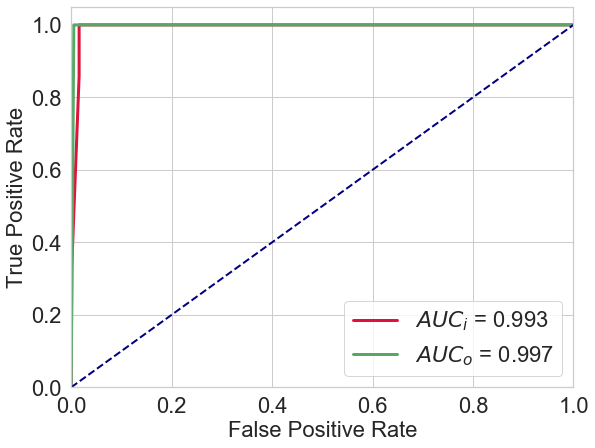

In [17]:
f=22
plt.figure(figsize=(9,7))
sns.set(style='whitegrid')
plt.plot(fpr0_imb, tpr0_imb, color='crimson', lw=3, label='$AUC_i$ = %.3f' % (roc_auc0_imb))
plt.plot(fpr0_or, tpr0_or, color='g', lw=3, label='$AUC_o$ = %.3f' % (roc_auc0_or))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=f)
plt.ylabel('True Positive Rate', fontsize=f)
#plt.title('ROC curve', fontsize=f)
plt.legend(loc="lower right", fontsize=f)
plt.tick_params(axis='both', which='major', labelsize=f)
plt.show()

Accuracy 0.9848570887753171
F1-score [0.99204929 0.84126984]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.73      1.00      0.84       212

    accuracy                           0.98      5283
   macro avg       0.86      0.99      0.92      5283
weighted avg       0.99      0.98      0.99      5283



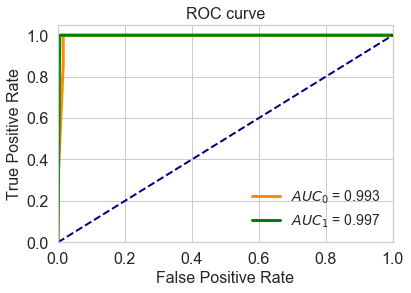

In [18]:
clf = DecisionTreeClassifier(min_samples_leaf=100, min_samples_split=10)
clf.fit(X_train, y_train)

def adjusted_predict(X_test, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

#Tutti questi comandi non servono, il grafico che si costruisce è identico a prima
y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr0_imb, tpr0_imb, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0_imb))
plt.plot(fpr0_or, tpr0_or, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc0_or))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [19]:
#clf = DecisionTreeClassifier(min_samples_leaf=100, min_samples_split=10)
#clf.fit(X_train, y_train)

def adjusted_predict(X_test, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

f1_score_l = []
precision_l = []
recall_l = []

for thr_k in range(2, 100, 2):
    y_pred = adjusted_predict(X_test, thr = thr_k/100)
    print('------------------------------')
    print(thr_k/100)
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    
    f1_score_l.append(f1_score(y_test, y_pred, average=None)[1])
    precision_l.append(report['1']['precision'])
    recall_l.append(report['1']['recall'])

       0.86      0.99      0.92      5283
weighted avg       0.99      0.98      0.99      5283

------------------------------
0.06
Accuracy 0.9848570887753171
F1-score [0.99204929 0.84126984]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.73      1.00      0.84       212

    accuracy                           0.98      5283
   macro avg       0.86      0.99      0.92      5283
weighted avg       0.99      0.98      0.99      5283

------------------------------
0.08
Accuracy 0.9848570887753171
F1-score [0.99204929 0.84126984]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.73      1.00      0.84       212

    accuracy                           0.98      5283
   macro avg       0.86      0.99      0.92      5283
weighted avg       0.99      0.98      0.99      5283

------------------------------
0.1
Accuracy 0.984857088

In [20]:
"""
proviamo vari valori di decision threshold per determinare il valore predetto della class target.
per il confronto, prendiamo i valori restituiti da clf.predict_proba()
"""

#clf = DecisionTreeClassifier(min_samples_leaf=100, min_samples_split=10)
#clf.fit(X_train, y_train)

def adjusted_predict(X_test, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1] # probabilità che sia 1
    return np.array([1 if y > thr else 0 for y in y_score]) # 1 se prob > threshold 0 altrimenti

f1_score_l = []
precision_l = []
recall_l = []
accuracy_l = []

for thr_k in range(2, 100, 2):
    y_pred = adjusted_predict(X_test, thr = thr_k/100)
    print('------------------------------')
    print(thr_k/100)
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    
    accuracy_l.append(accuracy_score(y_test, y_pred))
    f1_score_l.append(f1_score(y_test, y_pred, average=None)[1])
    precision_l.append(report['1']['precision'])
    recall_l.append(report['1']['recall'])

       0.86      0.99      0.92      5283
weighted avg       0.99      0.98      0.99      5283

------------------------------
0.06
Accuracy 0.9848570887753171
F1-score [0.99204929 0.84126984]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.73      1.00      0.84       212

    accuracy                           0.98      5283
   macro avg       0.86      0.99      0.92      5283
weighted avg       0.99      0.98      0.99      5283

------------------------------
0.08
Accuracy 0.9848570887753171
F1-score [0.99204929 0.84126984]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.73      1.00      0.84       212

    accuracy                           0.98      5283
   macro avg       0.86      0.99      0.92      5283
weighted avg       0.99      0.98      0.99      5283

------------------------------
0.1
Accuracy 0.984857088

Da thr > 0.88, tutti i record vengono classificati 0

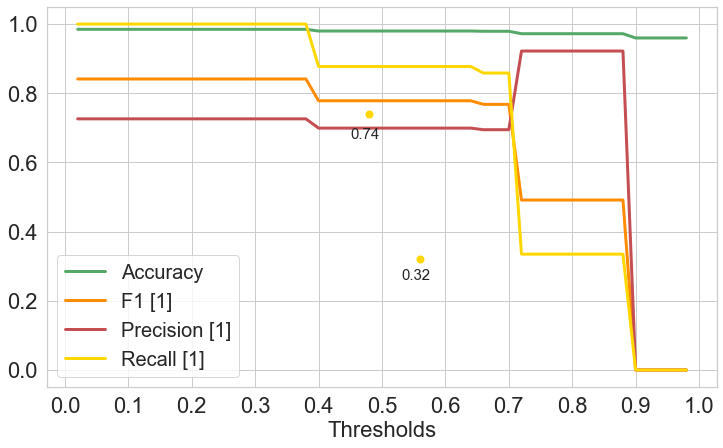

In [21]:
x = [i/100 for i in range(2, 100, 2)]

plt.figure(figsize=(12,7))
sns.set(style='whitegrid')
plt.plot(x, accuracy_l, color = 'g', lw = 3)
plt.plot(x, f1_score_l, color = 'darkorange', lw=3)
plt.plot(x, precision_l, color = 'r', lw=3)
plt.plot(x, recall_l, color = 'gold', lw=3)
plt.plot(0.48, 0.74, marker='o', color='gold', markersize=7)
plt.text(0.45, 0.67, '0.74', fontsize=15)
plt.plot(0.56, 0.32, marker='o', color='gold', markersize=7)
plt.text(0.53, 0.26, '0.32', fontsize=15)
plt.xlabel('Thresholds', fontsize=22)
plt.yticks(fontsize=f)
#plt.yticks([x/100 for x in range(65, 105, 5)], fontsize=f)
plt.xticks([x/100 for x in range(0, 110, 10)], fontsize=f)
plt.legend(['Accuracy', 'F1 [1]', 'Precision [1]', 'Recall [1]'], fontsize=20, loc='lower left')
plt.tick_params(axis='both', which='major', labelsize=f)
plt.show()